# This note book compare the compressed halo catalog with raw halo catalog

In [9]:
import numpy as np
from readers import HaloReader,SnapshotReader
from correlations import PowerSpectrum
from time import time
import gc

import matplotlib.pyplot as plt
import matplotlib.colors as pltcol
import pylab as pl

# Load the simulation and halo catalog

In [2]:
sim_stem = 'sinhagad/default256'
snap = 200
real = 1
grid = 128
downsample=0
Npmin = 30

Seed = 42
# start_time = time()
sr = SnapshotReader(sim_stem=sim_stem,real=real,snap=snap,read_header=False)
sr.read_snapshot_header()
pos = sr.read_block('pos',down_to=downsample,seed=Seed)
# vel = sr.read_block('vel',down_to=downsample,seed=Seed)
# ids = sr.read_block('ids',down_to=downsample,seed=Seed)

Snapshot Reader:
... preparing to read file: sinhagad/default256/r1/snapshot_200.hdf5
... loaded header and parameters
... reading Coordinates


# usual load halos from the raw file

In [6]:
hr = HaloReader(sim_stem=sim_stem,real=real,snap=snap)
QE = 0.5 # 0.5 recommended by Bett+07
massdef = 'm200b'
mmin = hr.mpart*Npmin
hpos,halos,vahc = hr.prep_halos(massdef=massdef,QE=QE,Npmin=Npmin,va=True)
#This line will load halos using the fits file
#hpos,halos = hr.prep_halos(massdef=massdef,QE=QE,Npmin=Npmin,use_fits=True)

Snapshot Reader:
... preparing to read file: sinhagad/default256/r1/snapshot_200.hdf5
... loaded header and parameters
... preparing halo data
... using file: sinhagad/default256/r1/out_200.trees
... ... using mass definition m200b > 1.245e+12 Msun/h
... ... only relaxed objects retained with 0.50 < 2T/|U| < 1.50
... ... discarding subhalos
... ... kept 27620 of 38606 objects in catalog
... using file: sinhagad/default256/r1/out_200.vahc
... ... sorting by m200b


# This is how you can call to convert the halos to fits file
If we want to do this by default then this line should be added in the post-process script after creating the halo catalog

* Note: currently the fits file uses the names in the header of the halo catalog. But the halo reader function rdefine some of the names (for example mvir-->mvir_all, ID->haloID). Also there are differences in capitalisation such as mvir and Mvir. We should think about what is best and use the consistent naming everywhere if possible.


In [6]:
hr.convert_halos_fits()

Fri Jun 14 12:57:39 2024 
	working on:  /Users/shadab/Documents/Projects/sahyadri-sandbox/Test/halos/sinhagad/default256/r1/out_200.trees
	output file:  /Users/shadab/Documents/Projects/sahyadri-sandbox/Test/halos/sinhagad/default256/r1/out_200_basic.fits.gz
0 Fri Jun 14 12:57:40 2024
**** closed:  /Users/shadab/Documents/Projects/sahyadri-sandbox/Test/halos/sinhagad/default256/r1/out_200_basic.fits.gz Fri Jun 14 12:57:40 2024
Fri Jun 14 12:57:40 2024 
	working on:  /Users/shadab/Documents/Projects/sahyadri-sandbox/Test/halos/sinhagad/default256/r1/out_200.trees
	output file:  /Users/shadab/Documents/Projects/sahyadri-sandbox/Test/halos/sinhagad/default256/r1/out_200_extended.fits.gz
0 Fri Jun 14 12:57:40 2024
**** closed:  /Users/shadab/Documents/Projects/sahyadri-sandbox/Test/halos/sinhagad/default256/r1/out_200_extended.fits.gz Fri Jun 14 12:57:41 2024
Fri Jun 14 12:57:41 2024 
	working on:  /Users/shadab/Documents/Projects/sahyadri-sandbox/Test/halos/sinhagad/default256/r1/out_200.

In [5]:
#!rm /Users/shadab/Documents/Projects/sahyadri-sandbox/Test/halos/sinhagad/default256/r1/out_200*.fits.gz

# Look at the file size
we get between 3-4 compression on these files

In [8]:
!ls -ltrh /Users/shadab/Documents/Projects/sahyadri-sandbox/Test/halos/sinhagad/default256/r1/o*

-rw-r--r--  1 shadab  staff    28M 13 Jun 13:00 /Users/shadab/Documents/Projects/sahyadri-sandbox/Test/halos/sinhagad/default256/r1/out_200.trees
-rw-r--r--  1 shadab  staff    11M 13 Jun 13:00 /Users/shadab/Documents/Projects/sahyadri-sandbox/Test/halos/sinhagad/default256/r1/out_200.vahc
-rw-r--r--  1 shadab  staff   1.7M 14 Jun 12:57 /Users/shadab/Documents/Projects/sahyadri-sandbox/Test/halos/sinhagad/default256/r1/out_200_basic.fits.gz
-rw-r--r--  1 shadab  staff   5.7M 14 Jun 12:57 /Users/shadab/Documents/Projects/sahyadri-sandbox/Test/halos/sinhagad/default256/r1/out_200_extended.fits.gz
-rw-r--r--  1 shadab  staff   4.1M 14 Jun 12:57 /Users/shadab/Documents/Projects/sahyadri-sandbox/Test/halos/sinhagad/default256/r1/out_200_vahc.fits.gz


# Now load halos from the fits.gz file using the compressed version

In [7]:
hpos_fits,halos_fits, vahc_fits = hr.prep_halos(massdef=massdef,QE=QE,Npmin=Npmin,use_fits=True,va=True)

... preparing halo data
... ... using mass definition M200b > 1.245e+12 Msun/h
... ... only relaxed objects retained with 0.50 < 2T/|U| < 1.50
... ... discarding subhalos
... ... kept 27620 of 38606 objects in catalog
... ... sorting by M200b


# Compare the halos loaded from the fits and raw file

Text(0.5, 1.0, 'Position difference')

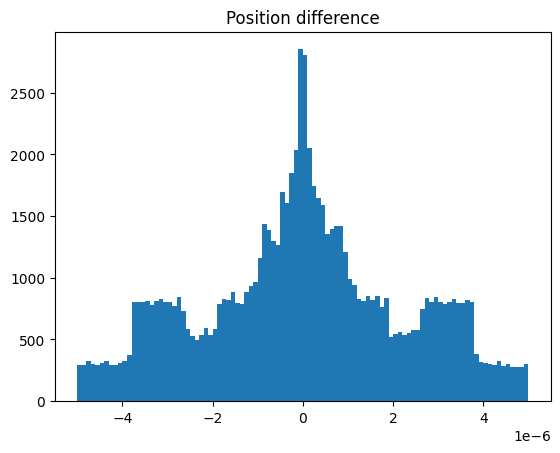

In [10]:
#difference in position
diff=hpos-hpos_fits
hh=pl.hist(diff.flatten(),bins=100)
pl.title('Position difference')


# Power spectrum using the raw file

In [13]:
pk_dic={'raw':{},'fits':{}}

In [14]:
ps = PowerSpectrum(grid=128,Lbox=sr.Lbox)
delta_dm = ps.density_field(pos)
FT_delta_dm = ps.fourier_transform_density(delta_dm)
pk_dic['raw']['mm'] = ps.Pk_grid(FT_delta_dm,input_is_FTdensity=True)

#Shadab: I had to change hpos to hpos.T because the first dimensions is checked for size 3
delta_h = ps.density_field(hpos.T)
FT_delta_h = ps.fourier_transform_density(delta_h)
pk_dic['raw']['hh'] = ps.Pk_grid(FT_delta_h,input_is_FTdensity=True)
pk_dic['raw']['hm'] = ps.Pk_grid(FT_delta_h,input_array2=FT_delta_dm,input_is_FTdensity=True)

pk_dic['raw']['hh'] -= ps.Lbox**3/(halos.size + ps.TINY)
if downsample > 0:
    pk_dic['raw']['mm'] -= ps.Lbox**3/(downsample**3)
else:
    pk_dic['raw']['mm'] -= ps.Lbox**3/(sr.npart)

# del pos#,vel,ids
# del delta_dm, FT_delta_dm,delta_h,FT_delta_h
# gc.collect()

sr.print_this('... done',ps.logfile)

Setting up k-space...
... using log binning
... creating mesh
... setting up index arrays
... done with setup
Computing density field...
... updating density
... deconvolving CIC filter
... calculating P(k)
Computing density field...
... updating density
... deconvolving CIC filter
... calculating P(k)
... calculating P(k)
... done


# Power spectrum using the fits form of halo catalogs

In [15]:
ps = PowerSpectrum(grid=128,Lbox=sr.Lbox)
delta_dm = ps.density_field(pos)
FT_delta_dm = ps.fourier_transform_density(delta_dm)
pk_dic['fits']['mm'] = ps.Pk_grid(FT_delta_dm,input_is_FTdensity=True)

#Shadab: I had to change hpos to hpos.T because the first dimensions is checked for size 3
delta_h = ps.density_field(hpos_fits.T)
FT_delta_h = ps.fourier_transform_density(delta_h)
pk_dic['fits']['hh'] = ps.Pk_grid(FT_delta_h,input_is_FTdensity=True)
pk_dic['fits']['hm'] = ps.Pk_grid(FT_delta_h,input_array2=FT_delta_dm,input_is_FTdensity=True)

pk_dic['fits']['hh'] -= ps.Lbox**3/(halos_fits.size + ps.TINY)
if downsample > 0:
    pk_dic['fits']['mm'] -= ps.Lbox**3/(downsample**3)
else:
    pk_dic['fits']['mm'] -= ps.Lbox**3/(sr.npart)

# del pos#,vel,ids
# del delta_dm, FT_delta_dm,delta_h,FT_delta_h
# gc.collect()

sr.print_this('... done',ps.logfile)

Setting up k-space...
... using log binning
... creating mesh
... setting up index arrays
... done with setup
Computing density field...
... updating density
... deconvolving CIC filter
... calculating P(k)
Computing density field...
... updating density
... deconvolving CIC filter
... calculating P(k)
... calculating P(k)
... done


In [ ]:
# outfile_Pk = sr.sim_path + sim_stem + '/r'+str(real)+'/Pk_{0:03d}.txt'.format(snap)
# sr.print_this('Writing to file: '+outfile_Pk,sr.logfile)
# f = open(outfile_Pk,'w')
# f.write("# P(k) (DM,halos,cross) from snapshot_{0:03d}\n".format(snap))
# down = downsample if downsample > 0 else np.rint(sr.npart**(1/3.)).astype(int)
# f.write("# grid = {0:d}; downsampled to ({1:d})^3 particles\n".format(grid,down))
# f.write("# Halos satisfy {0:.2f} < 2T/|U| < {1:.2f}\n".format(1.-QE,1.+QE))
# f.write("# "+massdef+" > {0:.4e} Msun/h\n".format(hr.mpart*Npmin))
# f.write("# k (h/Mpc) | P(k) (Mpc/h)^3 | Phalo | Pcross\n")
# f.close()
# for k in range(ps.ktab.size):
#     sr.write_to_file(outfile_Pk,[ps.ktab[k],Pk_mm[k],Pk_hh[k],Pk_hm[k]])
# sr.print_this('... done',ps.logfile)

# # sr.time_this(start_time)

Text(0, 0.5, 'Pk')

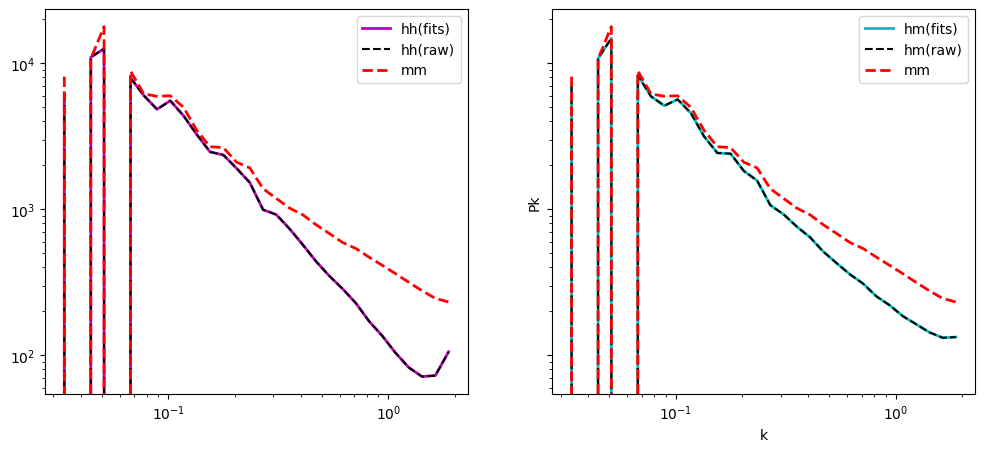

In [25]:
nrow=1;ncol=2
fig,axarr=pl.subplots(nrow,ncol,sharex=True,sharey=True,figsize=(6*ncol,nrow*5))
axarr=axarr.reshape(axarr.size)

tcol=['m','c']
for pp,ptype in enumerate(['hh','hm']):
    pl.sca(axarr[pp])
    pl.plot(ps.ktab,pk_dic['fits'][ptype],color=tcol[pp],ls='-',lw=2,label=ptype+ '(fits)')
    pl.plot(ps.ktab,pk_dic['raw'][ptype],color='k',ls='--',label=ptype+ '(raw)')
    
    #ALso plot the matter
    pl.plot(ps.ktab,pk_dic['fits']['mm'],color='r',ls='--',lw=2,label='mm')
    
    pl.legend()
    
pl.xscale('log')
pl.yscale('log')

pl.xlabel('k')
pl.ylabel('Pk')

# Space to test thing under development

In [12]:
tags = ['mvir','m200b','m200c'] 
ntags = len(tags)
mass_string = ''
for t in tags[:-1]: mass_string += t+','
mass_string += tags[-1]

lgmmin = np.log10(mmin)
lgmmax = 16.0
dlgm = 0.1
dlnm = dlgm*np.log(10)
nlgm = int((lgmmax-lgmmin)/dlgm)
mbins = np.logspace(lgmmin,lgmmax,nlgm+1)
mcenter = np.sqrt(mbins[1:]*mbins[:-1])

dndlnm = np.zeros((ntags,nlgm),dtype=float)
Vbox = sr.Lbox**3
for t in range(ntags):
    tag = tags[t]
    dndlnm[t],temp = np.histogram(halos[tag],bins=mbins,density=False)
    dndlnm[t] = dndlnm[t]/dlnm/Vbox
    if tag==massdef:
        sr.print_this("Nhalos: direct = {0:d}; integrated = {1:.1f}\n"
                      .format(halos.size,Vbox*dlnm*np.sum(dndlnm[t])),sr.logfile)

# outfile_mf = sr.halo_path + sim_stem + '/r'+str(real)+'/mf_{0:d}.txt'.format(snap)
# sr.print_this('Writing to file: '+outfile_mf,sr.logfile)
# fh = open(outfile_mf,'w')
# fh.write("#\n# Mass functions for " + sim_stem + '/'+'r'+str(real)+'/out_' + str(snap)+"\n")
# fh.write("# This file contains dn/dlnm (h/Mpc)^3 for various mass definitions.\n")
# fh.write("#\n# mass (Msun/h) | dndlnm["+mass_string+"]\n")
# fh.close()
# for m in range(nlgm):
#     mlist = [mcenter[m]]
#     for t in range(ntags):
#         mlist.append(dndlnm[t,m])
#     sr.write_to_file(outfile_mf,mlist)

Nhalos: direct = 27620; integrated = 27620.0



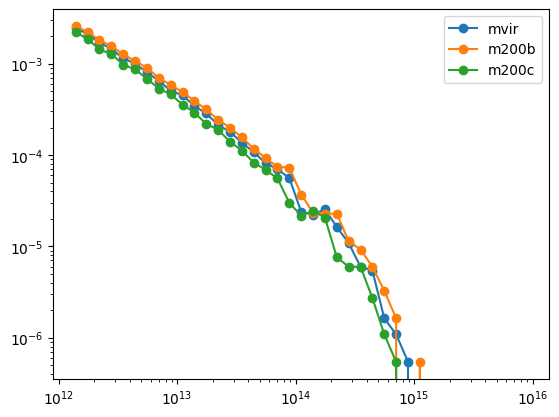

In [13]:
plt.yscale('log')
plt.xscale('log')
for t in range(ntags):
    plt.plot(mcenter,dndlnm[t],'-',marker='o',label=tags[t])#,drawstyle='steps-mid')
plt.legend()
plt.show()

In [1]:
!pwd

/Users/shadab/Documents/Projects/sahyadri-sandbox/scripts/post-process


In [2]:
import socket
socket.gethostname()

'Shadabs-MacBook-Pro.local'

In [7]:
#!rm -rf /Users/shadab/Documents/Projects/sahyadri-sandbox/Test/halos/sinhagad/default256/r1/o*.fits.gz
!ls -ltrh /Users/shadab/Documents/Projects/sahyadri-sandbox/Test/halos/sinhagad/default256/r1/o*.fits.gz

-rw-r--r--  1 shadab  staff   1.7M 14 Jun 09:55 /Users/shadab/Documents/Projects/sahyadri-sandbox/Test/halos/sinhagad/default256/r1/out_200_basic.fits.gz
-rw-r--r--  1 shadab  staff   5.8M 14 Jun 09:55 /Users/shadab/Documents/Projects/sahyadri-sandbox/Test/halos/sinhagad/default256/r1/out_200_extended.fits.gz
-rw-r--r--  1 shadab  staff   4.1M 14 Jun 09:55 /Users/shadab/Documents/Projects/sahyadri-sandbox/Test/halos/sinhagad/default256/r1/out_200_vahc.fits.gz


*** List of columns in this file ***: 
  file: /Users/shadab/Documents/Projects/sahyadri-sandbox/Test/halos/sinhagad/default256/r1/out_200_basic.fits.gz
  extension: 1
  type: BINARY_TBL
  rows: 38606
  column info:
    id                  i8  
    pid                 i8  
    Mvir                f4  
    rs                  f4  
    vrms                f4  
    x                   f4  
    y                   f4  
    z                   f4  
    vx                  f4  
    vy                  f4  
    vz                  f4  
    Mvir_all            f4  
    M200b               f4  
    M200c               f4  
    M500c               f4  
    M2500c              f4  
    T/|U|               f4  


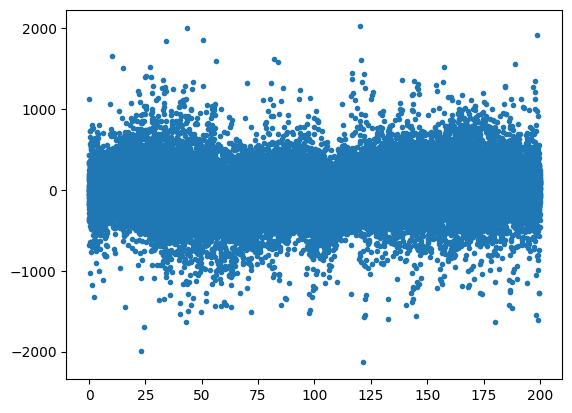

In [5]:
#Example for reading the file
#open fits file and plot x-vx
import fitsio as F
import pylab as pl
sim_dir='/Users/shadab/Documents/Projects/sahyadri-sandbox/Test/halos/sinhagad/default256/r1/'
with F.FITS(sim_dir+'out_200_basic.fits.gz') as fin:
    print('*** List of columns in this file ***:',fin[1])
    pl.plot(fin[1]['z'][:],fin[1]['vz'][:],'.')


In [13]:
hpos,halos = hr.prep_halos(massdef='mvir',QE=QE,Npmin=Npmin,keep_subhalos=True)

... preparing halo data
... using file: sinhagad/default256/r1/out_200.trees
... ... using mass definition mvir > 4.152e+13 Msun/h
... ... only relaxed objects retained with 0.50 < 2T/|U| < 1.50
... ... kept 757 of 38606 objects in catalog
... ... sorting by mvir


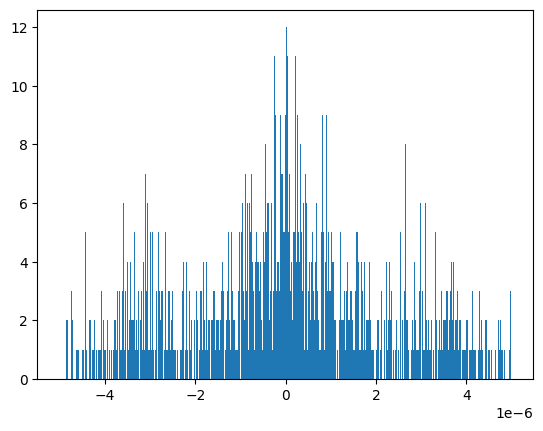

In [22]:
diff=hpos-fhpos

hh=pl.hist(diff.flatten(),bins=1000)

In [17]:
fhpos

array([[106.64967, 105.05318,  19.1902 ],
       [128.35397, 146.95132,  87.39196],
       [186.11716, 134.84659,  90.05529],
       ...,
       [198.28587,  16.61077,  43.09415],
       [178.82271, 111.74517,  23.02188],
       [189.24596, 136.15475, 120.90205]], dtype=float32)

In [81]:
massdef='mvir'
print(massdef[0],massdef[1:])
massdef='M'+massdef[1:]

print(massdef_new,massdef)

m vir
Mvir Mvir


In [84]:


sim_dir='/Users/shadab/Documents/Projects/sahyadri-sandbox/Test/halos/sinhagad/default256/r1/'
with F.FITS(sim_dir+'out_200_basic.fits.gz') as fbasic:
    with F.FITS(sim_dir+'out_200_vahc.fits.gz') as fext:
        #fhandle=[fbasic,fext]
        fhandle=fbasic
        if(False):
            dtype_all=fhandle[1][0].dtype
            dtype_names=fhandle[1][0].dtype.names
            print(dtype_all,len(dtype_all))

            for ii in range(0,len(dtype_all)):
                print(ii,dtype_names[ii],dtype_all[ii])
            print(dtype_all[0])
            for dd in dtype_all:
                print(dd)
            print(dtype_all)
            print(fhandle[1][0].dtype.names)
            print(np.recarray((2),dtype=fhandle[1][0].dtype))

        index=np.array([0,4,2,3,4])
        rec_array=fits_to_record(fhandle,index,list_sel_col=['Mvir','x','txx','lam1_R2R200b','Vpeak'])
        print(rec_array)
        #index=np.array([0,4,1,2,3])
        #rec_array=single_fits_to_record(fhandle,index,list_sel_col=['Mvir','x'])
        #print(rec_array)

*** Warning *** 
 Following field were requested but not found in the files
2 txx
3 lam1_R2R200b
4 Vpeak
[(9.243e+14, 189.24596) (5.585e+14, 149.32777) (6.476e+14, 198.28587)
 (5.866e+14,   8.12195) (5.585e+14, 149.32777)]


In [43]:
type([])

list

In [13]:
!head /Users/shadab/Documents/Projects/sahyadri-sandbox/Test/halos/sinhagad/default256/r1/out_200.trees

#scale(0) id(1) desc_scale(2) desc_id(3) num_prog(4) pid(5) upid(6) desc_pid(7) phantom(8) sam_Mvir(9) Mvir(10) Rvir(11) rs(12) vrms(13) mmp?(14) scale_of_last_MM(15) vmax(16) x(17) y(18) z(19) vx(20) vy(21) vz(22) Jx(23) Jy(24) Jz(25) Spin(26) Breadth_first_ID(27) Depth_first_ID(28) Tree_root_ID(29) Orig_halo_ID(30) Snap_idx(31) Next_coprogenitor_depthfirst_ID(32) Last_progenitor_depthfirst_ID(33) Last_mainleaf_depthfirst_ID(34) Tidal_Force(35) Tidal_ID(36) Rs_Klypin(37) Mvir_all(38) M200b(39) M200c(40) M500c(41) M2500c(42) Xoff(43) Voff(44) Spin_Bullock(45) b_to_a(46) c_to_a(47) A[x](48) A[y](49) A[z](50) b_to_a(500c)(51) c_to_a(500c)(52) A[x](500c)(53) A[y](500c)(54) A[z](500c)(55) T/|U|(56) M_pe_Behroozi(57) M_pe_Diemer(58) Halfmass_Radius(59) Macc(60) Mpeak(61) Vacc(62) Vpeak(63) Halfmass_Scale(64) Acc_Rate_Inst(65) Acc_Rate_100Myr(66) Acc_Rate_1*Tdyn(67) Acc_Rate_2*Tdyn(68) Acc_Rate_Mpeak(69) Acc_Log_Vmax_Inst(70) Acc_Log_Vmax_1*Tdyn(71) Mpeak_Scale(72) Acc_Scale(73) First_Acc_Sc